In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from math import floor
from sklearn import linear_model
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from matplotlib.dates import date2num
import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

In [5]:
crsp_daily = pd.read_csv('/Users/frederikfindsen/Documents/Økonomi/8. Semester/Seminar/crsp_daily.csv',index_col='date',parse_dates=True)
factors_ff = pd.read_csv('/Users/frederikfindsen/Documents/Økonomi/8. Semester/Seminar/factors_daily.csv',index_col='date',parse_dates=True)
cointegration_pairs = pd.read_excel("/Users/frederikfindsen/Documents/Økonomi/8. Semester/Seminar/cointegration_pair.xlsx",index_col = 'date', parse_dates = True)


In [6]:
data = crsp_daily.reset_index().pivot(index='date',columns='permno',values='ret_excess').iloc[:,0:1000]

#Making returns to closing prices
start = 100
for column in data:
    data[column] = start*(1+data[column]).cumprod()

## Trading Strategy

In [91]:
class trading_log:
    
    def __init__(self,show_message=True):
        #Creating position variables
        pos_type = 'none' #Can take following form: 'long', 'short', 'none'
        pos_status = 'closed' #Can take following form: 'open', 'closed'
        portfolio_log = pd.DataFrame(columns=['price','pos_type','pos_status','time','profit'])
        portfolio_log.loc[portfolio_log.shape[0]] = [0,'none','closed',0,0]

        
        self.show_message = show_message
        self.portfolio = portfolio_log
        
    def open_short(self,time,price):
        
        if (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'): #If trade already executed
                    pass #Next time period

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'): #If long trade ongoing, opening new short trade
            pos_status = 'open'
            pos_type = 'short'
            price = price
            time = time
            profit = price - self.portfolio['price'].iloc[-1]
            
            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

        elif self.portfolio['pos_status'].iloc[-1] == 'closed': #Opening a new trade
            pos_status = 'open'
            pos_type = 'short'
            price = price
            time = time
            profit = 0
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
        
    def open_long(self,time,price):
        if (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'): #If trade already executed
            pass #Next time period

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'): #If short trade ongoing, opening new long trade
            pos_status = 'open'
            pos_type = 'long'
            price = price
            time = time
            profit =self.portfolio['price'].iloc[-1]-price
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
            
        elif self.portfolio['pos_status'].iloc[-1] == 'closed': #Opening a new trade
            pos_status = 'open'
            pos_type = 'long'
            price = price
            time = time
            profit = 0
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            
            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
    
    def close(self,time,price):
        if self.portfolio['pos_status'].iloc[-1] == 'closed':
            pass

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'):
            pos_status = 'closed'
            pos_type = 'long'
            price = price
            time = time
            profit = price - self.portfolio['price'].iloc[-1]
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))


        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'):
            pos_status = 'closed'
            pos_type = 'short'
            price = price
            time = time
            profit =self.portfolio['price'].iloc[-1]-price
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
    
    def finish_trade(self,time,price):

        if self.portfolio.shape[0] == 1:
            pos_status = 'closed'
            pos_type = 'none'
            price = price
            time = time
            profit = 0

            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            self.profit = 0
        
            if self.show_message == True:
                print("Trading window is closed, no trade signals triggered.")
        else:  
            pos_status = 'closed'
            pos_type = 'none'
            price = price
            time = time
            profit = self.portfolio['price'].iloc[-1]-price

            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            self.profit = (((1+self.portfolio['profit']/100).cumprod())-1).iloc[-1]

            if self.show_message == True:
                    print("Trading window is closed, closing trade. Total profit of: " + str(round(self.profit,3)))



In [174]:
class tradingstrategy:
    
    def __init__(self,data, mkt_data,cointegration_pairs):
        self.data = data
        self.market_data = mkt_data
        self.cointegration_pairs = cointegration_pairs
        
    def define_highlow_date(self, mkt_return):

        mod_kns = sm.tsa.MarkovRegression(
            mkt_return, k_regimes=2, switching_variance=True
                )

        res_kns = mod_kns.fit(search_reps=20)

        #low_dates = res_kns.smoothed_marginal_probabilities[1].index
        #high_dates = res_kns.smoothed_marginal_probabilities[0].index
        
        low_dates = list()
        high_dates = list()
        
        for value, date in zip(res_kns.smoothed_marginal_probabilities[0],res_kns.smoothed_marginal_probabilities[1].index):
            if value > 0.8:
                low_dates.append(date)
            else:
                high_dates.append(date)
        
        self.low_dates = low_dates
        self.high_dates = high_dates
        
        if res_kns.smoothed_marginal_probabilities[0][-1] > 0.8:
            curr_regime = 'low'
        else:
            curr_regime = 'high'
        
            
        return curr_regime, low_dates, high_dates

    
    def trade(self,start_date='01-01-2011',end_date='2012-03-01',trading_window=1,n_pairs=20):
        
        performance = pd.DataFrame({'date':[],'vasicek':[],'cointegration':[]})
        
        #Trading rolling
        
        for date in pd.date_range(start_date,end_date,freq=f'{trading_window}MS'):
            if date > pd.to_datetime('2014-12-31')-relativedelta(days=trading_window):
                break
                
            self.date = date
            self.create_pairs(n_pairs=n_pairs)
            
            print('Pairs created for date ' + str(date))
            
            
            vasicek_profits = list()
            cointegration_profits = list()
            
            for pairs in self.vasicek_pairs.iterrows(): #Trading vasicek
                one_trade = self.trade_vasicek(self.data[[int(pairs[1]['stocka']),int(pairs[1]['stockb'])]],trading_window=trading_window)
                vasicek_profits.append(one_trade.profit)
                
            
            
            for pairs in self.coint_pairs.iterrows(): #Trading cointegration
                one_trade = self.trade_coint(self.data[[int(pairs[1]['stocka']),int(pairs[1]['stockb'])]],regime=self.curr_regime,trading_window=trading_window)
                cointegration_profits.append(one_trade.profit)
                
            
            #Performance is the average of N pairs return in the trading window
            performance.loc[performance.shape[0]] = [date, float(np.mean(vasicek_profits)),float(np.mean(cointegration_profits))]

            
        self.performance = performance.set_index('date')
        
        
    def create_pairs(self,n_pairs):
        
        window = 5 #years
        five_years_ago = self.date - relativedelta(years=window) #Getering the data point five years ago
        
        
        data = self.data.loc[five_years_ago:self.date] #Getting the last five years of data
        cols = ~data.loc[five_years_ago:self.date].isnull().any() #Removing all columns with NA before date, no Forward looking bias
        data = data.loc[:,cols] #Selecting the columns 
        
        #Normalizing returns:
        start = 100
        for column in data:
            data[column] = (data[column]/data[column].iloc[0])*100

        
        self.coint_pairs = self.pairs_cointegration(self.cointegration_pairs,n_pairs)
        self.vasicek_pairs = self.test_vasicek(data,n_pairs)
        
        self.curr_regime, low_dates, high_dates = self.define_highlow_date(self.market_data['mkt_excess'].loc[five_years_ago:self.date])
                        
    def pairs_cointegration(self,data,number_pairs):
        
        data = data.loc[self.date].copy()
        
        data = data.reset_index().drop('date',axis=1)
        pairs_coint = data.nsmallest(number_pairs, 'pvalues')
        
        return pairs_coint
    
    
    def test_cointegration(self,data,number_pairs):
        #Data is the return dataframe
        n =  (len(data.columns) - 1)
        stocks = data.iloc[:,1:].columns.values
        data = data.to_numpy()
        pvalue_matrix = np.zeros((n,n),dtype = float)
        pairs = np.empty((n*n,2),dtype=object)
        m = 0
        
        pair_df = pd.DataFrame({'stocka':[],'stockb':[],'p-value':[]})
        
        for i in tqdm(range(0,n)):
            for j in range(0,n):
                S1 = data[:,i+1]
                S2 = data[:,j+1]
                result = ts.coint(S1,S2)
                pvalue_matrix[i,j] = result[1]
                #storing all paris in matrix form

                if (result[1] < 0.05) & (i!=j):
                    pairs[m,0] = stocks[i]
                    pairs[m,1] = stocks[j]

                    pair_df.loc[pair_df.shape[0]] = [int(stocks[i]),int(stocks[j]),result[1]]

                    m = m+1

        pairs = pair_df.nsmallest(number_pairs, 'p-value')
        
        
        return pvalue_matrix,  pairs
        
        
        
    def fit_ols(self, data):
            
        Y = data.shift(1)
        X = sm.add_constant(data)

        model = sm.OLS(Y,X)
        results = model.fit()
        
    def spread(self,x,y):
        regr = linear_model.LinearRegression()
        x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
        regr.fit(x_constant, y)    
        beta = regr.coef_[0]
        alpha = regr.intercept_
        spread = y - x*beta

        return spread, beta
    
    def test_vasicek(self, data, number_pairs):
            
        pair_df = pd.DataFrame({'stocka':[],'stockb':[],'SSD':[]})

        for i in tqdm(data.columns):
            try:
                for j in data.columns:

                    if i == j:
                        pass
                    else:
                        S1 = data[i]
                        S2 = data[j]
                        result = np.sum((S1-S2)**2)

                        #Storing results

                        pair_df.loc[pair_df.shape[0]] = [int(i),int(j),result]
            except:
                pass
        
        pair_df.drop_duplicates('SSD',inplace=True)
        pairs = pair_df.nsmallest(number_pairs, 'SSD')
        
        return pairs
    

    def estimate_vasicek(self, A, B):
        
        #Estimating the Vasicek model using MLE
        spread = (A - B).to_numpy()
        
        #Setting up all relevant variables
        n = len(spread)-1
        Sx = np.sum(spread[0:len(spread)-1])
        Sy = np.sum(spread[1:len(spread)])
        Sxx = np.sum(spread[0:len(spread)-1]**2)
        Sxy = np.sum(spread[0:len(spread)-1]*spread[1:len(spread)])
        Syy = np.sum(spread[1:len(spread)]**2)
        
        
        #Estimating parameters
        theta = (Sy*Sxx-Sx*Sxy)/(n*(Sxx-Sxy)-(Sx**2-Sx*Sy))
        kappa =  (( Sxy-theta*Sx-theta*Sy+n*theta**2)/(Sxx-2*theta*Sx+n*theta**2))
        a = 1-kappa
        sigmah2 = (Syy-2*a*Sxy+a**2*Sxx-2*theta*(1-a)*(Sy-a*Sx)+n*theta**2*(1-a)**2)/n
        sigma = np.sqrt(sigmah2*2*kappa/(1-a**2))
        
        return kappa, theta, sigma
    
    def trade_coint(self, data, trading_window, regime,threshold=1.96):
        
        portfolio_log = trading_log(show_message=False)
        
        #try:
        #Normalzing data
        for column in data.columns:
            data[column] = (data[column]/data[column].iloc[0])*100

        data.columns = ['p','q']

        #Defining test and train data
        test_data = data.loc[self.date:self.date + relativedelta(months=trading_window)] 
        train_data = data.loc[:self.date]

        test_data = self.normalize(test_data)
        train_data = self.normalize(train_data)
        spread_train, beta_train = self.spread(train_data['p'],train_data['q'])


        curr_regime, low_dates, high_dates = self.define_highlow_date(spread_train)


        if regime == 'high':
            data = data.loc[high_dates]
            spread, beta = self.spread(train_data['p'],train_data['q'])

        elif regime == 'low':
            data = data.loc[low_dates]
            spread, beta = self.spread(train_data['p'],train_data['q'])

        # Compute rolling mean and rolling standard deviation

        #Generating z-score
        st = test_data['p']-beta*test_data['q']
        st_mean = st.mean()
        st_std = st.std()

        zscore =(st-st_mean)/st_std
        #Trading


        #We log each trade in the portfolio_log dataframe
        for i in range(len(zscore)):

            # Sell short if the z-score is > 1
            if zscore[i] > threshold:
                portfolio_log.open_short(i,zscore[i])

            # Buy long if the z-score is < -1
            elif zscore[i] < -threshold:
                portfolio_log.open_long(i,zscore[i])

            # Clear positions if the z-score between -.5 and .5
            elif abs(zscore[i]) < 0.5:
                portfolio_log.close(i,zscore[i])

            if i == len(zscore)-1:#End of period close of trade
                portfolio_log.finish_trade(i,zscore[i])
        #except:
        #    portfolio_log.finish_trade(0,0)
            

        return portfolio_log
    
    def normalize(self, data):
        norm_data = data.copy()
        for column in norm_data.columns:
            norm_data[column] = (norm_data[column]/norm_data[column].iloc[0])*100
            
        return norm_data
    
    def trade_vasicek(self, data, trading_window, threshold = 1.65):
        
        portfolio_log = trading_log(show_message=False)
        
        #try:
        
        data.columns = ['p','q']
        #Defining test and train data

        test_data = data.loc[self.date:self.date + relativedelta(months=trading_window)] 
        train_data = data.loc[:self.date]

        test_data = self.normalize(test_data)
        train_data = self.normalize(train_data)
        spread_train = train_data['p'] - train_data['q']

        curr_regime, low_dates, high_dates = self.define_highlow_date(spread_train)


        if curr_regime == 'high':
            data = data.loc[high_dates]
            kappa, theta, sigma = self.estimate_vasicek(train_data['p'],train_data['q'])

        elif curr_regime == 'low':
            data = data.loc[low_dates]
            kappa, theta, sigma = self.estimate_vasicek(train_data['p'],train_data['q'])

        #Generating the score for buy/sell signals
        spread = test_data['p'] - test_data['q']
        ratio = kappa*(theta-spread)+sigma*threshold

        for i in range(len(spread)):

            # Sell short if the z-score is > 1
            if spread[i] > kappa*(theta+spread[i-1])+threshold*sigma:
                portfolio_log.open_short(i,spread[i])

            # Buy long if the z-score is < -1
            elif spread[i] < kappa*(theta+spread[i-1])-threshold*sigma:
                portfolio_log.open_long(i,spread[i])

            # Close else
            else:
                portfolio_log.close(i,spread[i])

            if i == len(spread)-1:#End of period close of trade
                portfolio_log.finish_trade(i,spread[i])

        #except:
        #    print("Error in estimation")
        #    portfolio_log.finish_trade(0,0)
            
        return portfolio_log
    
    def evaluate_performance(self):
        
        performance_list = list()
        
        
        for j in range(10,40,10):
            performance_df = pd.DataFrame()
            for i in range(1,4):
                vas_name = 'trad_'+str(j)+'_pair_'+str(i)+'_vas'
                coint_name = 'trad_'+str(j)+'_pair_'+str(i)+'_coint'
                
                self.trade(start_date='2011-01-01',end_date='2012-03-01',trading_window = i,n_pairs=j)
                
                vasicek = self.performance['vasicek']
                coint = self.performance['cointegration']
                
                performance_df[vas_name] = vasicek
                performance_df[coint_name] = coint
                
            performance_list.append(performance_df)
                
        self.performance_list = performance_list
        
        
        return performance_list
        


In [87]:
class trading_log:
    
    def __init__(self,show_message=True):
        #Creating position variables
        pos_type = 'none' #Can take following form: 'long', 'short', 'none'
        pos_status = 'closed' #Can take following form: 'open', 'closed'
        portfolio_log = pd.DataFrame(columns=['price','pos_type','pos_status','time','profit'])
        portfolio_log.loc[portfolio_log.shape[0]] = [0,'none','closed',0,0]

        
        self.show_message = show_message
        self.portfolio = portfolio_log
        
    def open_short(self,time,price):
        
        if (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'): #If trade already executed
                    pass #Next time period

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'): #If long trade ongoing, opening new short trade
            pos_status = 'open'
            pos_type = 'short'
            price = price
            time = time
            profit = price - self.portfolio['price'].iloc[-1]
            
            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

        elif self.portfolio['pos_status'].iloc[-1] == 'closed': #Opening a new trade
            pos_status = 'open'
            pos_type = 'short'
            price = price
            time = time
            profit = 0
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
        
    def open_long(self,time,price):
        if (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'): #If trade already executed
            pass #Next time period

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'): #If short trade ongoing, opening new long trade
            pos_status = 'open'
            pos_type = 'long'
            price = price
            time = time
            profit =self.portfolio['price'].iloc[-1]-price
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
            
        elif self.portfolio['pos_status'].iloc[-1] == 'closed': #Opening a new trade
            pos_status = 'open'
            pos_type = 'long'
            price = price
            time = time
            profit = 0
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            
            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
    
    def close(self,time,price):
        if self.portfolio['pos_status'].iloc[-1] == 'closed':
            pass

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'):
            pos_status = 'closed'
            pos_type = 'long'
            price = price
            time = time
            profit = price - self.portfolio['price'].iloc[-1]
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))


        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'):
            pos_status = 'closed'
            pos_type = 'short'
            price = price
            time = time
            profit =self.portfolio['price'].iloc[-1]-price
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
    
    def finish_trade(self,time,price):

        if self.portfolio.shape[0] == 1:
            pos_status = 'closed'
            pos_type = 'none'
            price = price
            time = time
            profit = 0

            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            self.profit = 0
        
            if self.show_message == True:
                print("Trading window is closed, no trade signals triggered.")
        else:  
            pos_status = 'closed'
            pos_type = 'none'
            price = price
            time = time
            profit = self.portfolio['price'].iloc[-1]-price

            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            self.profit = (((1+self.portfolio['profit']/100).cumprod())-1).iloc[-1]

            if self.show_message == True:
                    print("Trading window is closed, closing trade. Total profit of: " + str(round(self.profit,3)))



In [ ]:
trading = tradingstrategy(data,factors_ff,cointegration_pairs)
trading.trade()

  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/213 [00:00<?, ?it/s]

Pairs created for date 2011-02-01 00:00:00


  0%|          | 0/212 [00:00<?, ?it/s]

Pairs created for date 2011-03-01 00:00:00


  0%|          | 0/210 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00


  0%|          | 0/206 [00:00<?, ?it/s]

Pairs created for date 2011-06-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-08-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-09-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-10-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-11-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-12-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/198 [00:00<?, ?it/s]

Pairs created for date 2012-02-01 00:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

Pairs created for date 2012-03-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/212 [00:00<?, ?it/s]

Pairs created for date 2011-03-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-09-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-11-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

Pairs created for date 2012-03-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/210 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-10-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/213 [00:00<?, ?it/s]

Pairs created for date 2011-02-01 00:00:00


  0%|          | 0/212 [00:00<?, ?it/s]

Pairs created for date 2011-03-01 00:00:00


  0%|          | 0/210 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00


  0%|          | 0/206 [00:00<?, ?it/s]

Pairs created for date 2011-06-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-08-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-09-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-10-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-11-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-12-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/198 [00:00<?, ?it/s]

Pairs created for date 2012-02-01 00:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

Pairs created for date 2012-03-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/212 [00:00<?, ?it/s]

Pairs created for date 2011-03-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-09-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-11-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

Pairs created for date 2012-03-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/210 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-10-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/213 [00:00<?, ?it/s]

Pairs created for date 2011-02-01 00:00:00


  0%|          | 0/212 [00:00<?, ?it/s]

Pairs created for date 2011-03-01 00:00:00


  0%|          | 0/210 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00


  0%|          | 0/206 [00:00<?, ?it/s]

Pairs created for date 2011-06-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-08-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-09-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-10-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-11-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-12-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/198 [00:00<?, ?it/s]

Pairs created for date 2012-02-01 00:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

Pairs created for date 2012-03-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/212 [00:00<?, ?it/s]

Pairs created for date 2011-03-01 00:00:00


  0%|          | 0/209 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-09-01 00:00:00


  0%|          | 0/204 [00:00<?, ?it/s]

Pairs created for date 2011-11-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

Pairs created for date 2012-03-01 00:00:00


  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00


  0%|          | 0/210 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00


  0%|          | 0/205 [00:00<?, ?it/s]

Pairs created for date 2011-07-01 00:00:00


  0%|          | 0/203 [00:00<?, ?it/s]

Pairs created for date 2011-10-01 00:00:00


  0%|          | 0/202 [00:00<?, ?it/s]

Pairs created for date 2012-01-01 00:00:00


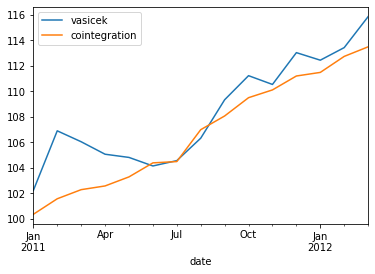

In [133]:
((1+trading.performance[['vasicek','cointegration']]).cumprod()*100).plot()
benchmark = factors_ff['mkt_excess'].loc[trading.performance.index[0]:trading.performance.index[-1]].to_frame()
benchmark = benchmark.resample('M').agg(lambda x: (x + 1).prod() - 1)
vasicek_ret = trading.performance['vasicek']
cointegration_ret = trading.performance['cointegration']

In [122]:
def evaluation(returns,benchmark):
    
    eval_df = pd.DataFrame(index = ['Annualized Return','Annualized Std.', 
                                      ' Sharpe Ratio', 
                                      'Minimum','Maximum',
                                      'Max Drawdown',
                                      'Beta',
                                      'Observations'])
    
    for column in returns.columns:
        metrics_list = list()
        
        
        annualized_return = returns[column].mean()*12
        annualized_std = returns[column].std()*np.sqrt(12)
        sharpe_ratio = (returns[column].mean()/returns[column].std())
        minimum = returns[column].min()
        maximum = returns[column].max()
        max_drawdown = empyrical.max_drawdown(returns[column])
        beta = empyrical.beta(returns[column],benchmark)
        observations = len(returns[column])
        
        
        metrics_list.append(annualized_return)
        metrics_list.append(annualized_std)
        metrics_list.append(sharpe_ratio)
        metrics_list.append(minimum)
        metrics_list.append(maximum)
        metrics_list.append(max_drawdown)
        metrics_list.append(beta)
        metrics_list.append(observations)
        
        eval_df[column] = metrics_list
        
    for column in benchmark.columns:
        metrics_list = list()
        
        
        annualized_return = benchmark[column].mean()*12
        annualized_std = benchmark[column].std()*np.sqrt(12)
        sharpe_ratio = (benchmark[column].mean()/benchmark[column].std())
        minimum = benchmark[column].min()
        maximum = benchmark[column].max()
        max_drawdown = empyrical.max_drawdown(benchmark[column])
        beta = empyrical.beta(benchmark[column],benchmark)
        observations = len(benchmark[column])
        
        
        metrics_list.append(annualized_return)
        metrics_list.append(annualized_std)
        metrics_list.append(sharpe_ratio)
        metrics_list.append(minimum)
        metrics_list.append(maximum)
        metrics_list.append(max_drawdown)
        metrics_list.append(beta)
        metrics_list.append(observations)
        
        eval_df[column] = metrics_list
    
    return eval_df
    
eval_df = evaluation(trading.performance,benchmark)
        
eval_df.to_latex()

'\\begin{tabular}{lrrr}\n\\toprule\n{} &    vasicek &  cointegration &  mkt\\_excess \\\\\n\\midrule\nAnnualized Return &   0.119856 &       0.101873 &    0.005463 \\\\\nAnnualized Std.   &   0.057099 &       0.019756 &    0.049620 \\\\\n Sharpe Ratio     &   0.605958 &       1.488537 &    0.031785 \\\\\nMinimum           &  -0.009228 &       0.000987 &   -0.069700 \\\\\nMaximum           &   0.045805 &       0.023921 &    0.049700 \\\\\nMax Drawdown      &  -0.025775 &       0.000000 &   -0.203263 \\\\\nBeta              &   0.559795 &      -0.025492 &    1.000000 \\\\\nObservations      &  15.000000 &      15.000000 &  293.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

### Figures 

In [79]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return ax

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,6),facecolor = "white")

axes[0].plot(((1+trading.performance[['vasicek','cointegration']]).cumprod()*100))
axes[0].plot(((1+benchmark).cumprod())*100)

index = np.arange(len(trading.performance.index))
bar_width = 0.3
axes[1].bar(index, trading.performance['vasicek'], bar_width)
axes[1].bar(index + bar_width, trading.performance['cointegration'], bar_width)
axes[1].bar(index + bar_width + bar_width, benchmark['mkt_excess'], bar_width)
axes[1].set_xticklabels(trading.performance.index)

axes[0].set_ylabel("Index, 2011/01/01=100")
axes[1].set_ylabel("Return")

axes[0].tick_params(axis='x', labelrotation = 45)
axes[1].tick_params(axis='x', labelrotation = 45)

axes[0] = simpleaxis(axes[0])
axes[1] = simpleaxis(axes[1])

fig.subplots_adjust(bottom=0.02)
fig.tight_layout(rect=(0,0.1,1,1))

fig.legend(["Vasicek", 'Co-Integration','Benchmark'],loc="lower center",
          frameon=False,
          ncol=3)


#fig.savefig("spread_vasicek.jpg")

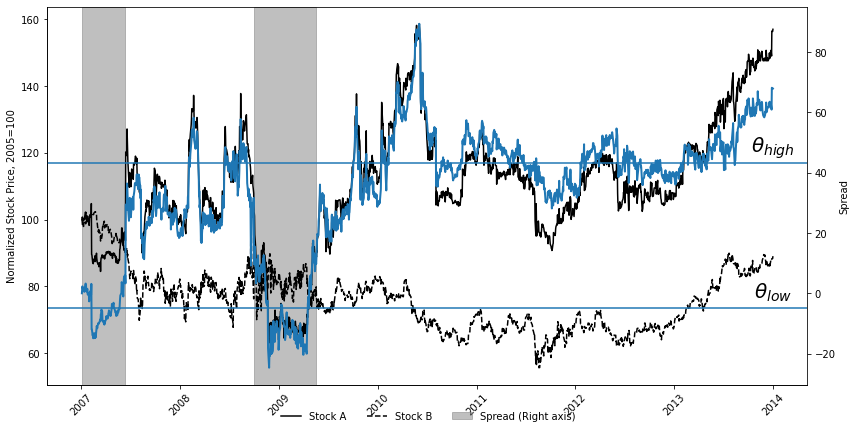

In [80]:
stock1 = 11368
stock2 = 12073


plot_data = (trading.normalize(data[[stock1,stock2]].loc['2007-01-01':'2014-01-01']))
spread = plot_data[stock1]-plot_data[stock2]

curr_regime, low_dates, high_dates = trading.define_highlow_date(spread)

kappa_low, theta_low, sigma_low = trading.estimate_vasicek(plot_data[stock1].loc[low_dates],plot_data[stock2].loc[low_dates])
kappa_high, theta_high, sigma_high = trading.estimate_vasicek(plot_data[stock1].loc[high_dates],plot_data[stock2].loc[high_dates])




fig, axes = plt.subplots(1,figsize=(12,6),facecolor = "white")

ax2 = axes.twinx()
axes.plot(plot_data[stock1],color="black")
axes.plot(plot_data[stock2],color="black",linestyle='dashed')
ax2.plot(spread,linewidth=2)



axes.axvspan(date2num(datetime(2007,1,3)), date2num(datetime(2007,6,13)), color="grey", alpha=0.5) #Manually located from the low_dates list
axes.axvspan(date2num(datetime(2008,10,1)), date2num(datetime(2009,5,19)), color="grey", alpha=0.5) #Manually located from the low_dates list

ax2.axhline(theta_high)
ax2.axhline(theta_low)

ax2.text(date2num(datetime(2014,1,1)), theta_high+5, '$\\theta_{high}$', fontsize=20, va='center', ha='center')
ax2.text(date2num(datetime(2014,1,1)), theta_low+5, '$\\theta_{low}$', fontsize=20, va='center', ha='center')



axes.set_ylabel("Normalized Stock Price, 2005=100")
ax2.set_ylabel('Spread')

axes.tick_params(axis='x', labelrotation = 45)
axes = simpleaxis(axes)

fig.legend(["Stock A", 'Stock B', 'Spread (Right axis)'],loc="lower center",
          frameon=False,
          ncol=3)



fig.subplots_adjust(bottom=0.02)
fig.tight_layout()

fig.savefig("spread_vasicek_markov.jpg")

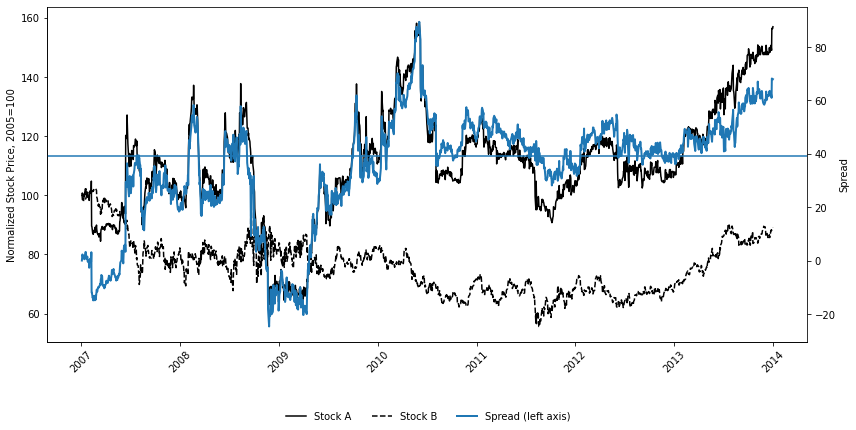

In [572]:
stock1 = 11368
stock2 = 12073


plot_data = (trading.normalize(data[[stock1,stock2]].loc['2007-01-01':'2014-01-01']))
spread = plot_data[stock1]-plot_data[stock2]

curr_regime, low_dates, high_dates = trading.define_highlow_date(spread)

    
kappa, theta, sigma = trading.estimate_vasicek(plot_data[stock1],plot_data[stock2])

fig, axes = plt.subplots(1,figsize=(12,6),facecolor = "white")

ax2 = axes.twinx()
axes.plot(plot_data[stock1],color="black")
axes.plot(plot_data[stock2],color="black",linestyle='dashed')
ax2.plot(spread,linewidth=2)

#axes.axvspan(date2num(datetime(2007,1,3)), date2num(datetime(2007,6,13)), color="grey", alpha=0.5) #Manually located from the low_dates list
#axes.axvspan(date2num(datetime(2008,10,1)), date2num(datetime(2009,5,19)), color="grey", alpha=0.5) #Manually located from the low_dates list

ax2.axhline(theta)
axes.set_ylabel("Normalized Stock Price, 2005=100")
ax2.set_ylabel('Spread')

axes.tick_params(axis='x', labelrotation = 45)
axes = simpleaxis(axes)


fig.subplots_adjust(bottom=0.02)
fig.tight_layout(rect=(0,0.1,1,1))

fig.legend(["Stock A", 'Stock B', 'Spread (Right axis)'],loc="lower center",
          frameon=False,
          ncol=3)


fig.savefig("spread_vasicek.jpg")